# Retirement Planner

---

## Environment Setup

In [2]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
C:\Users\brett\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [4]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv(dotenv_path = 'C:/Users/brett/Desktop/FTBC/.env')

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [6]:
# Display sample data
df.head()

AGG     SPY
                             close   close
time                                      
2019-01-02 00:00:00-05:00  106.585  249.89
2019-01-03 00:00:00-05:00  107.020  244.46
2019-01-04 00:00:00-05:00  106.695  252.41
2019-01-07 00:00:00-05:00  106.470  254.40
2019-01-08 00:00:00-05:00  106.420  256.65

---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [8]:
# Calculate the daily roi for the stocks
daily_returns = df.pct_change()
# Display sample data
daily_returns.head()

AGG       SPY
                              close     close
time                                         
2019-01-02 00:00:00-05:00       NaN       NaN
2019-01-03 00:00:00-05:00  0.004081 -0.021730
2019-01-04 00:00:00-05:00 -0.003037  0.032521
2019-01-07 00:00:00-05:00 -0.002109  0.007884
2019-01-08 00:00:00-05:00 -0.000470  0.008844

In [11]:
# Compute daily volatility
daily_return_std_dev_agg = daily_returns.std()['AGG']['close']
daily_return_std_dev_spy = daily_returns.std()['SPY']['close']
daily_return_std_dev_spy

0.007820053413439366

In [12]:
# Save the last day's closing price
agg_last_price = df['AGG']['close'][-1]
spy_last_price = df['SPY']['close'][-1]

In [13]:
# Setup the Monte Carlo Parameters
# number_simulations = 500
# number_records = 252 * 30
number_simulations = 100
number_records = 252
monte_carlo_df = pd.DataFrame()
cumulative_portfolio_returns = pd.DataFrame()

In [14]:
# Run the Monte Carlo Simulation
for sim in range(number_simulations):
    
    # Initialize the simulated prices list iwth the last closing price
    agg_simulated_prices = [agg_last_price]
    spy_simulated_prices = [spy_last_price]
    
    # Simulate returns for 30 years
    for rec in range(number_records):
        
        # Use last price to calculate the simulated price
        agg_simulated_price = agg_simulated_prices[-1] * (1 + np.random.normal(
            (daily_returns.mean()['AGG']['close']),daily_return_std_dev_agg))
        
        spy_simulated_price = spy_simulated_prices[-1] * (1 + np.random.normal(
            (daily_returns.mean()['SPY']['close']),daily_return_std_dev_spy))
        
        # Append to list
        agg_simulated_prices.append(agg_simulated_price)
        spy_simulated_prices.append(spy_simulated_price)
        
    # Append sim prices to monte_carlo dataframe
    monte_carlo_df['AGG Prices'] = pd.Series(agg_simulated_prices)
    monte_carlo_df['SPY Prices'] = pd.Series(spy_simulated_prices)
    
    #Calculate daily returns of the monte_carlo Dataframe
    monte_carlo_daily_returns = monte_carlo_df.pct_change()
    
    # Set weights to SPY: 60% and AGG: 40%
    weights = [0.40, 0.60]
    
    # Apply the weights to the portfolio's simulated daily returns
    portfolio_daily_returns = monte_carlo_daily_returns.dot(weights)
    
    # Calculate cumulated return of simulation
    cumulative_portfolio_returns[sim] = (1 + portfolio_daily_returns.fillna(0)).cumprod() 

In [32]:
# Check that the simulation ran successfully
cumulative_portfolio_returns.head()

0         1         2         3         4         5         6   \
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1  1.000476  0.997880  0.999075  0.991352  0.991086  1.014863  0.997323   
2  1.008876  0.994048  1.001810  0.991420  0.986552  1.014401  1.000291   
3  1.008286  0.990918  1.001019  0.996312  0.988585  1.018200  1.000736   
4  1.013963  0.991611  1.004111  1.004833  0.984340  1.022178  0.996273   

         7         8         9   ...        90        91        92        93  \
0  1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000  1.000000   
1  0.994245  0.986426  0.999467  ...  1.005394  1.001639  0.999261  0.996445   
2  1.004861  0.990886  1.003586  ...  0.996711  1.006145  1.001694  0.997198   
3  0.999645  0.990987  1.012585  ...  0.998232  1.007330  1.007635  0.994463   
4  1.009584  0.988468  1.008922  ...  1.002636  1.008249  1.018017  0.995863   

         94        95        96        97        98        99  
0  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1  1.005226  0.997743  1.003976  1.004226  1.001111  1.004769  
2  1.002921  0.998864  0.998407  1.006465  0.996208  1.008757  
3  1.003288  0.995496  1.004124  1.002999  1.004500  1.004422  
4  1.008363  1.002826  0.998479  1.001615  1.009096  1.003590  

[5 rows x 100 columns]

Text(0.5, 0, 'Simulations')

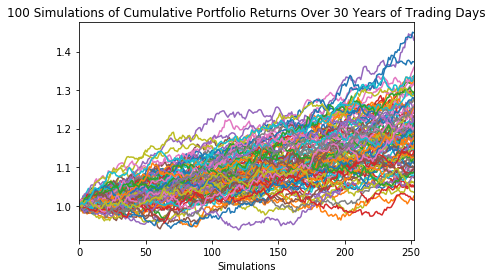

In [33]:
# Visualize the Simulation
plot_title = f"{sim + 1} Simulations of Cumulative Portfolio Returns Over 30 Years of Trading Days"
ax= cumulative_portfolio_returns.plot(title=plot_title, legend=None)
ax.set_xlabel("Simulations")

In [24]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
final_cumulative_returns = cumulative_portfolio_returns.iloc[-1,:]
final_cumulative_returns.head()

0    1.222232
1    1.275656
2    1.333686
3    1.287483
4    1.250288
Name: 252, dtype: float64

In [30]:
# Display the 90% confidence interval for the ending returns
confidence_interval = final_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    1.059040
0.95    1.333875
Name: 252, dtype: float64

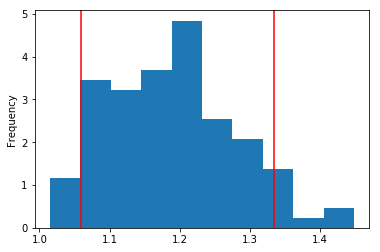

In [31]:
# Visualize the distribution of the ending returns
plt.figure();
final_cumulative_returns.plot(kind='hist', density=True)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [34]:
# Compute cumulative returns
confidence_interval_b = final_cumulative_returns.quantile(q=[0.10, 0.50, 0.90])
confidence_interval_b

0.1    1.083975
0.5    1.187794
0.9    1.297434
Name: 252, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [57]:
# Set initial investment
initial_investment = 20000
# Compute expected portfolio return
investment_pnl_lower = round(initial_investment + (initial_investment * confidence_interval_b.iloc[0]),2)
investment_pnl_middle = round(initial_investment + (initial_investment * confidence_interval_b.iloc[1]),2)
investment_pnl_upper = round(initial_investment + (initial_investment * confidence_interval_b.iloc[2]), 2)

print(f'10th Percentile: ${investment_pnl_lower}\n50th Percentile: ${investment_pnl_middle}\n90th Percentile: ${investment_pnl_upper}')

10th Percentile: $41679.5
50th Percentile: $43755.89
90th Percentile: $45948.68


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [61]:
# Set Plaid's projected income
plaid_projected_income = 7389
# Calculate the 4% withdrawal for the ending return as retirement income
four_percent_withdrawal = round(investment_pnl_lower * 0.04, 2)
# Determine if the retirement income meets or exceeds the current projected income
if four_percent_withdrawal == plaid_projected_income:
    print(f"Your 4% retirement withdrawal of ${four_percent_withdrawal} is equal to your projected yearly income of ${plaid_projected_income}.")
elif four_percent_withdrawal > plaid_projected_income:
    print(f"Your 4% retirement withdrawal of ${four_percent_withdrawal} exceeds your projected yearly income of ${plaid_projected_income}!")
else:
   print(f"I'm sorry but your 4% retirement withdrawal of ${four_percent_withdrawal} is below your projected yearly income of ${plaid_projected_income}.")

I'm sorry but your 4% retirement withdrawal of $1667.18 is below your projected yearly income of $7389.


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [63]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount
# Set initial investment
increased_initial_investment = 30000

# Compute expected portfolio return
increased_investment_pnl_lower = round(increased_initial_investment + (increased_initial_investment * confidence_interval_b.iloc[0]),2)
increased_investment_pnl_middle = round(increased_initial_investment + (increased_initial_investment * confidence_interval_b.iloc[1]),2)
increased_investment_pnl_upper = round(increased_initial_investment + (increased_initial_investment * confidence_interval_b.iloc[2]), 2)

# Set Plaid's projected income
plaid_projected_income = 7389
# Calculate the 4% withdrawal for the ending return as retirement income
four_percent_withdrawal_increased = round(increased_investment_pnl_lower * 0.04, 2)

# Determine if the retirement income meets or exceeds the current projected income
if four_percent_withdrawal == plaid_projected_income:
    print(f"Your 4% retirement withdrawal of ${four_percent_withdrawal_increased} is equal to your projected yearly income of ${plaid_projected_income}.")
elif four_percent_withdrawal > plaid_projected_income:
    print(f"Your 4% retirement withdrawal of ${four_percent_withdrawal_increased} exceeds your projected yearly income of ${plaid_projected_income}!")
else:
   print(f"I'm sorry but your 4% retirement withdrawal of ${four_percent_withdrawal_increased} is below your projected yearly income of ${plaid_projected_income}.")

I'm sorry but your 4% retirement withdrawal of $2500.77 is below your projected yearly income of $7389.


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# Compute projected returns

# Display sample data


In [ ]:
# Plot the cumulative returns over time


In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
